In [1]:
# Disable some console warnings
import os
os.environ['TF_XLA_FLAGS'] = '--tf_xla_enable_xla_devices'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [2]:
import sys 
sys.path.append('../training')
import pickle

from save_data import process_data

import hls4ml 
import numpy as np
import matplotlib.pyplot as plt 
from sklearn.metrics import accuracy_score
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, BatchNormalization, Dropout
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.losses import CategoricalCrossentropy

from tensorflow_model_optimization.python.core.sparsity.keras import prune, pruning_callbacks, pruning_schedule
from tensorflow_model_optimization.sparsity.keras import strip_pruning
import tensorflow_model_optimization as tfmot

from qkeras.qlayers import QDense, QActivation
from qkeras import QBatchNormalization
from qkeras.quantizers import quantized_bits, quantized_relu
from qkeras.utils import _add_supported_quantized_objects
from tensorflow.keras.models import load_model
from qkeras.utils import _add_supported_quantized_objects

# os.environ['PATH'] = os.environ['XILINX_VIVADO'] + '/bin:' + os.environ['PATH']

## Configure

In [3]:
# START_WINDOW = 285
# END_WINDOW = 385

# START_WINDOW = 150
# END_WINDOW = 350

# START_WINDOW = 150
# END_WINDOW = 550

# START_WINDOW = 0
# END_WINDOW = 770

# START_WINDOW = 1
# END_WINDOW = 769

START_WINDOW = 5
END_WINDOW = 765

# START_WINDOW = 0
# END_WINDOW = 770

### Enable/disable training

In [4]:
TRAIN = False

## Setup data

In [5]:
def one_hot_encode(data):
    y_encoded = np.zeros([data.shape[0],2], dtype=np.int32)
    for idx, x in enumerate(data):
        if x == 1:
            y_encoded[idx][1] = 1
        else:
            y_encoded[idx][0] = 1
    return y_encoded

In [6]:
!mkdir -p models

DATA_DIR = f'../data/qick_data/{START_WINDOW}_{END_WINDOW}'
MODEL_DIR = f'models/model_{START_WINDOW}_{END_WINDOW}'

# convert raw ADC data into npy files 
if os.path.exists(f'{DATA_DIR}/X_train_{START_WINDOW}_{END_WINDOW}.npy') == False:
    process_data(
        start_window=START_WINDOW, 
        end_window=END_WINDOW, 
        data_dir=DATA_DIR
    )

In [7]:
# load data
X_train_val = np.load(os.path.join(DATA_DIR, f'X_train_{START_WINDOW}_{END_WINDOW}.npy'))
X_test = np.load(os.path.join(DATA_DIR, f'X_test_{START_WINDOW}_{END_WINDOW}.npy'))    
y_train_val = np.load(os.path.join(DATA_DIR, f'y_train_{START_WINDOW}_{END_WINDOW}.npy'))
y_test = np.load(os.path.join(DATA_DIR, f'y_test_{START_WINDOW}_{END_WINDOW}.npy'))

y_train_val = one_hot_encode(y_train_val)
y_test = one_hot_encode(y_test)

print('Window:')
print('  - Couples I/Q :', (END_WINDOW-START_WINDOW))
print('  - Model inputs:', (END_WINDOW-START_WINDOW)*2)

print('Training:')
print('  - Size        :', X_train_val.shape[0])
print('  - Sample Shape:', X_train_val.shape[1])
print('  - Mean        :', X_train_val.mean())
print('  - Std. Dev.   :', X_train_val.std())

print('Testing:')
print('  - Size        :', X_test.shape[0])
print('  - Sample Shape:', X_test.shape[1])
print('  - Mean        :', X_test.mean())
print('  - Std. Dev.   :', X_test.std())

assert len(X_train_val[0]) == (END_WINDOW-START_WINDOW)*2, 'ERROR: Specified window does not match loaded dataset shape'
assert len(X_test[0]) == (END_WINDOW-START_WINDOW)*2, 'ERROR: Specified window does not match loaded dataset shape'

Window:
  - Couples I/Q : 760
  - Model inputs: 1520
Training:
  - Size        : 909000
  - Sample Shape: 1520
  - Mean        : -49.117290508656126
  - Std. Dev.   : 1757.589208763786
Testing:
  - Size        : 101000
  - Sample Shape: 1520
  - Mean        : -42.50818295987494
  - Std. Dev.   : 1755.7636962188137


## Construct a model 
QKeras is 'Quantized Keras' for deep heterogeneous quantization of ML models. We're using QDense layer instead of Dense. We're also training with model sparsity, since QKeras layers are prunable.

In [8]:
INIT_LEARNING_RATE = 1e-2
VALIDATION_SPLIT = 0.3
BATCH_SIZE = 12800
EPOCHS = 50
CHECKPOINT_FILENAME = MODEL_DIR + f'/qmodel_{START_WINDOW}_{END_WINDOW}.h5'
INPUT_SHAPE = (X_train_val.shape[1],)

In [9]:
if TRAIN:
    input_size = (END_WINDOW-START_WINDOW)*2

    # Define model with quantize layers 
    model = Sequential()
    model.add(QDense(2, input_shape=(input_size,), name='fc1', kernel_quantizer=quantized_bits(6,0,alpha=1), bias_quantizer=quantized_bits(6,0,alpha=1),))
    model.add(BatchNormalization())

    # # Define model with quantize layers 
    # model = Sequential()
    # model.add(QDense(160, input_shape=(input_size,), name='fc1', kernel_quantizer=quantized_bits(6,0,alpha=1), bias_quantizer=quantized_bits(6,0,alpha=1),))
    # model.add(QActivation(activation=quantized_relu(6), name='relu1'))
    # model.add(BatchNormalization(name='batchnorm1'))
    # model.add(QDense(25, input_shape=(input_size,), name='fc2', kernel_quantizer=quantized_bits(6,0,alpha=1), bias_quantizer=quantized_bits(6,0,alpha=1),))
    # model.add(QActivation(activation=quantized_relu(6), name='relu2'))
    # model.add(BatchNormalization(name='batchnorm2'))
    # model.add(QDense(2, input_shape=(input_size,), name='fc3', kernel_quantizer=quantized_bits(6,0,alpha=1), bias_quantizer=quantized_bits(6,0,alpha=1),))
    # model.add(BatchNormalization(name='batchnorm3'))
    
    # adding pruning 
    pruning_params = {'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(initial_sparsity=0.50, final_sparsity=0.80, begin_step=200, end_step=1000)}
    model = prune.prune_low_magnitude(model, **pruning_params)

    print('=============================Model Summary=============================')
    print(model.summary())
    print('=======================================================================')
else:
    print('Training is disabled, load model from file')

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089
=============================Model Summary=============================
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 prune_low_magnitude_fc1 (Pr  (None, 2)                6084      
 uneLowMagnitude)                                                
                                                                 
 prune_low_magnitude_batch_n  (None, 2)                9         
 ormalization (PruneLowMagni                                     
 tude)                                                           
                                                                 
Total params: 6,093
Trainable params: 3,046
Non-trainable params: 3,047
_________________________________________

In [10]:
if TRAIN:
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        INIT_LEARNING_RATE,
        decay_steps=100000,
        decay_rate=0.96,
        staircase=True
    )

    callbacks = [
            ModelCheckpoint(
            CHECKPOINT_FILENAME,
            monitor='val_loss',
            verbose=0,
            save_best_only=True,
            save_weights_only=False,
            save_freq='epoch',
        ),
        ReduceLROnPlateau(patience=75, min_delta=1**-6),
        pruning_callbacks.UpdatePruningStep(),
    ]
else:
    print('Training is disabled, load model from file')

## Train the model 

In [11]:
if TRAIN:
    opt = Adam(learning_rate=INIT_LEARNING_RATE)
    model.compile(
        optimizer=opt, 
        # loss=tf.keras.losses.BinaryCrossentropy(),
        loss=CategoricalCrossentropy(from_logits=True), 
        metrics=['accuracy']
    )

    history = model.fit(
        X_train_val, 
        y_train_val, 
        batch_size=BATCH_SIZE,
        epochs=EPOCHS, 
        validation_split=VALIDATION_SPLIT, 
        shuffle=True, 
        callbacks=callbacks
    )
else:
    print('Training is disabled, load model from file')

Epoch 1/50
50/50 [==============================] - 3s 42ms/step - loss: 0.2262 - accuracy: 0.9468 - val_loss: 0.3127 - val_accuracy: 0.8732 - lr: 0.0100
Epoch 2/50
50/50 [==============================] - 1s 15ms/step - loss: 0.1734 - accuracy: 0.9608 - val_loss: 0.2009 - val_accuracy: 0.9439 - lr: 0.0100
Epoch 3/50
50/50 [==============================] - 1s 13ms/step - loss: 0.1624 - accuracy: 0.9625 - val_loss: 0.1698 - val_accuracy: 0.9589 - lr: 0.0100
Epoch 4/50
50/50 [==============================] - 1s 15ms/step - loss: 0.1588 - accuracy: 0.9633 - val_loss: 0.1742 - val_accuracy: 0.9624 - lr: 0.0100
Epoch 5/50
50/50 [==============================] - 1s 16ms/step - loss: 0.1597 - accuracy: 0.9637 - val_loss: 0.1634 - val_accuracy: 0.9631 - lr: 0.0100
Epoch 6/50
50/50 [==============================] - 1s 17ms/step - loss: 0.1585 - accuracy: 0.9636 - val_loss: 0.1738 - val_accuracy: 0.9610 - lr: 0.0100
Epoch 7/50
50/50 [==============================] - 1s 15ms/step - loss: 0.1

Important: Pruning layers must be removed before saving to disk. 

In [12]:
if TRAIN:
    model = strip_pruning(model)
    model.save(CHECKPOINT_FILENAME)

    history_file = CHECKPOINT_FILENAME.replace('.h5', '-history.pkl')
    with open(history_file, 'wb') as file_pi:
        pickle.dump(history.history, file_pi)

    print(f'Saving history to: {history_file}')
    print(f'Saved checkpoint to: {CHECKPOINT_FILENAME}')
else:
    print('Training is disabled, load model from file')

Saving history to: models/model_5_765/qmodel_5_765-history.pkl
Saved checkpoint to: models/model_5_765/qmodel_5_765.h5


## Check performance

todo: add ROC curve

In [13]:
co = {}
_add_supported_quantized_objects(co)
model = load_model(CHECKPOINT_FILENAME, custom_objects=co, compile=False)
y_pred = model.predict(X_test)

print('Keras accuracy: {}, inputs {}, I/Qs {}'.format(accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1)), (END_WINDOW-START_WINDOW)*2, (END_WINDOW-START_WINDOW)))

3157/3157 [==============================] - 4s 1ms/step
Keras accuracy: 0.9612277227722772, inputs 1520, I/Qs 760


If you run with the model and data on files, you should expect
```
Keras accuracy: 0.9614851485148515, inputs 1540, I/Qs 770
Keras accuracy: 0.9613564356435643, inputs 1536, I/Qs 768
Keras accuracy: 0.9612277227722772, inputs 1520, I/Qs 760
Keras accuracy: 0.9535643564356435, inputs 800, I/Qs 400
Keras accuracy: 0.9291980198019802, inputs 400, I/Qs 200
Keras accuracy: 0.8572376237623762, inputs 200, I/Qs 100
```

In [14]:
print('=============================Model Summary=============================')
print(model.summary())
print('=======================================================================')

=============================Model Summary=============================
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 fc1 (QDense)                (None, 2)                 3042      
                                                                 
 batch_normalization (BatchN  (None, 2)                8         
 ormalization)                                                   
                                                                 
Total params: 3,050
Trainable params: 3,046
Non-trainable params: 4
_________________________________________________________________
None


## Check sparsity 

Number of layers: 2
mkdir: cannot create directory ‘images’: File exists
% of zeros = 0.8
% of zeros = 0.0


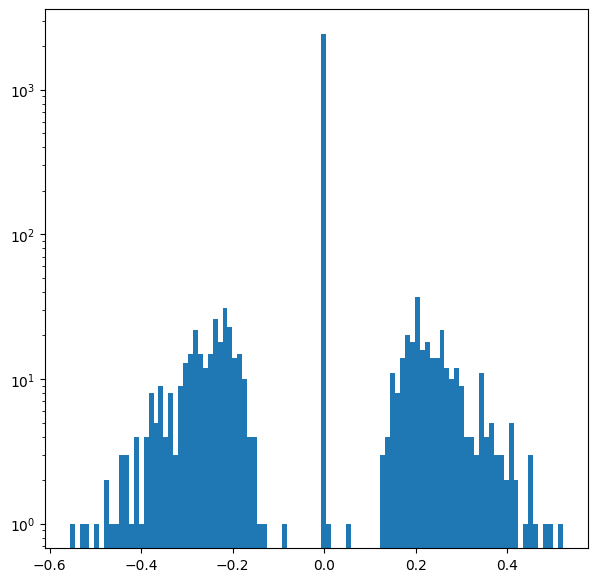

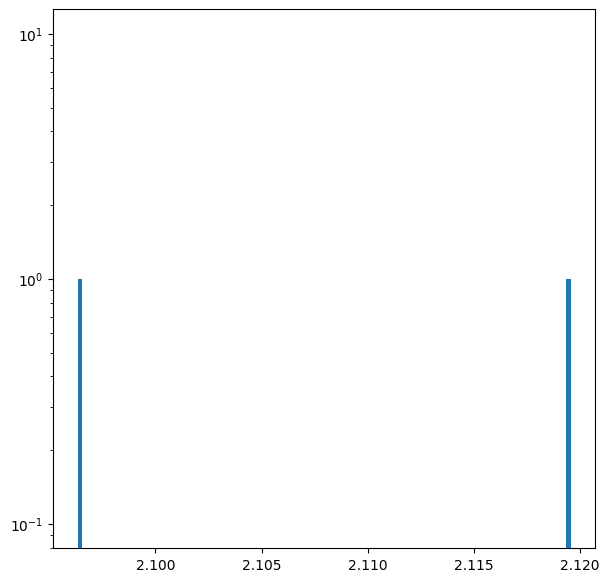

In [15]:
num_layers = len(model.layers)
print(f'Number of layers: {num_layers}')

!mkdir images

for idx in range(num_layers):
    w = model.layers[idx].weights[0].numpy()
    h, b = np.histogram(w, bins=100)

    # plot weight distribution
    plt.figure(figsize=(7, 7))
    plt.bar(b[:-1], h, width=b[1] - b[0])
    plt.semilogy()
    plt.savefig(f'images/model-dist-idx{idx}_{START_WINDOW}_{END_WINDOW}.png')

    print('% of zeros = {}'.format(np.sum(w == 0) / np.size(w)))

## Build the HLS model 

In [16]:
sys.path.append('../utils')
from config import print_dict

from tensorflow.keras.models import load_model
from qkeras.utils import _add_supported_quantized_objects

In [17]:
# Load checkpoint 
co = {}
_add_supported_quantized_objects(co)
model = load_model(CHECKPOINT_FILENAME, custom_objects=co, compile=False)
y_pred = model.predict(X_test)

# Re-evalulate 
y_keras = model.predict(X_test)
print(f'Model acc: {accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_keras, axis=1))}')
print(model.summary()) 

3157/3157 [==============================] - 4s 1ms/step
Model acc: 0.9612277227722772
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 fc1 (QDense)                (None, 2)                 3042      
                                                                 
 batch_normalization (BatchN  (None, 2)                8         
 ormalization)                                                   
                                                                 
Total params: 3,050
Trainable params: 3,046
Non-trainable params: 4
_________________________________________________________________
None


In [18]:
# Create HLS configuration 
HLSConfig = {}
HLSConfig['Model'] = {}
HLSConfig['Model']['Precision'] = 'ap_fixed<16,6>'  # Default precision
HLSConfig['Model']['ReuseFactor'] = 1  # fully parallelized 

HLSConfig['LayerName'] = {}
for layer in ['fc1_input', 'fc1', 'fc1_linear', 'batch_normalization']:
    HLSConfig['LayerName'][layer] = {}
    HLSConfig['LayerName'][layer]['Precision'] = {}
    HLSConfig['LayerName'][layer]['Trace'] = True

# Input - ZCU216 uses 14-bit ADCS 
HLSConfig['LayerName']['fc1_input']['Precision'] = 'ap_fixed<14,14>' 
# Fc
HLSConfig['LayerName']['fc1']['Precision']['result'] = 'ap_fixed<18,18>'
HLSConfig['LayerName']['fc1']['accum_t'] = 'ap_fixed<18,18>'
# Fc Linear
HLSConfig['LayerName']['fc1_linear']['Precision']['result'] = 'ap_fixed<18,18>'
# Batchnormalization
HLSConfig['LayerName']['batch_normalization']['Precision']['scale'] = 'ap_fixed<20,3>'
HLSConfig['LayerName']['batch_normalization']['Precision']['bias'] = 'ap_fixed<20,3>'
HLSConfig['LayerName']['batch_normalization']['Precision']['result'] = 'ap_fixed<16,6>'

print_dict(HLSConfig)

Model
  Precision:         ap_fixed<16,6>
  ReuseFactor:       1
LayerName
  fc1_input
    Precision:       ap_fixed<14,14>
    Trace:           True
  fc1
    Precision
      result:        ap_fixed<18,18>
    Trace:           True
    accum_t:         ap_fixed<18,18>
  fc1_linear
    Precision
      result:        ap_fixed<18,18>
    Trace:           True
  batch_normalization
    Precision
      scale:         ap_fixed<20,3>
      bias:          ap_fixed<20,3>
      result:        ap_fixed<16,6>
    Trace:           True


In [19]:
OutputDir = f'hls4ml_prjs/NN_{START_WINDOW}_{END_WINDOW}_prj'
!rm -rf '{OutputDir}'
!rm -f '{OutputDir}.tar.gz'
XilinxPart = 'xczu49dr-ffvf1760-2-e'
IOType = 'io_parallel'
#IOType = 'io_stream'
ClockPeriod = 3.225  # 3.225ns (307.2 MHz)
HLSFig = f'images/model_{START_WINDOW}_{END_WINDOW}.png'

hls_model = hls4ml.converters.convert_from_keras_model(
    model=model,
    hls_config=HLSConfig,
    output_dir=OutputDir,
    part=XilinxPart,
    io_type=IOType,
    clock_period=ClockPeriod,
    project_name='NN'
)

print(f'Creating hls4ml project directory {OutputDir}')
hls_model.compile()  # Must compile for C Sim. 

# Visualize model
hls4ml.utils.plot_model(
    hls_model, show_shapes=True, show_precision=True, to_file=HLSFig
)

Interpreting Sequential
Topology:
Layer name: fc1_input, layer type: InputLayer, input shapes: [[None, 1520]], output shape: [None, 1520]
Layer name: fc1, layer type: QDense, input shapes: [[None, 1520]], output shape: [None, 2]
Layer name: batch_normalization, layer type: BatchNormalization, input shapes: [[None, 2]], output shape: [None, 2]
Creating HLS model
Creating hls4ml project directory hls4ml_prjs/NN_5_765_prj
Writing HLS project


Done


## Check performance

In [20]:
# Trace output 
y_hls = hls_model.predict(np.ascontiguousarray(X_test.astype(np.float32))) 
y_hls = np.argmax(y_hls, axis=1)

print(f'Keras Acc: {accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_keras, axis=1))*100:.5}%')
print(f'HLS Acc  : {accuracy_score(np.argmax(y_test, axis=1), y_hls)*100:.5}:%')
print(f'CKA      : {accuracy_score(np.argmax(y_keras, axis=1), y_hls)*100:.5}%')

Keras Acc: 96.123%
HLS Acc  : 96.139:%
CKA      : 99.834%


## Correlation plots (Keras vs HLS)
Let's compare the output of the Qkeras and HLS model. If properly configured, the HLS activations will be aligned with the Qkeras model. 

In [21]:
_, hls_trace = hls_model.trace(np.ascontiguousarray(X_test.astype(np.float32))) 
keras_trace = hls4ml.model.profiling.get_ymodel_keras(model, X_test.astype(np.float32)) 

print(f'HLS Keys: {hls_trace.keys()}')
print(f'Keras Keys: {keras_trace.keys()}')

Recompiling NN with tracing
Writing HLS project


Done
3157/3157 [==============================] - 4s 1ms/step
Done taking outputs for Keras model.
HLS Keys: dict_keys(['fc1', 'batch_normalization'])
Keras Keys: dict_keys(['fc1', 'batch_normalization'])


fc1 		 139.9432
hls/keras min: -66801.0/-66652.21875
hls/keras max: 67215.0/67353.8125
batch_normalization 		 0.088678285
hls/keras min: -5.9267578125/-5.9770684242248535
hls/keras max: 5.4306640625/5.9530229568481445


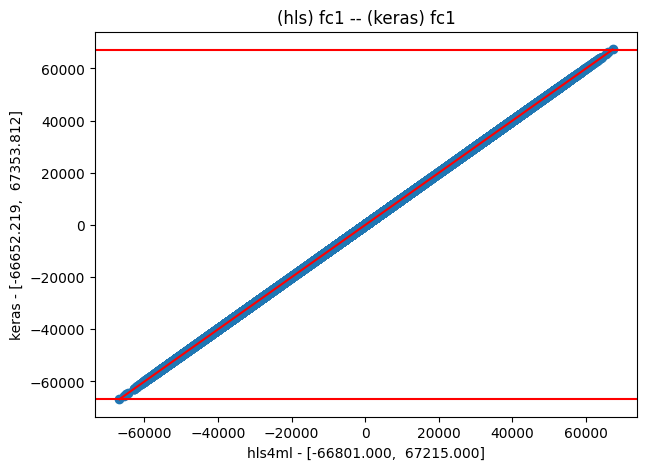

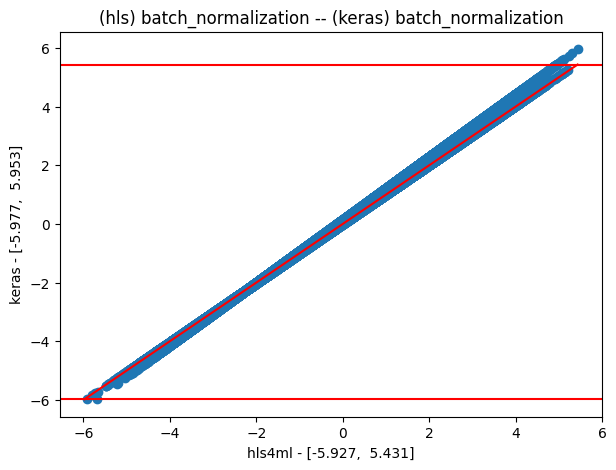

In [22]:
layers = ['fc1', 'batch_normalization']

for idx, layer in enumerate(layers):
    keras_layer, hls_layer = keras_trace[layer], hls_trace[layer]
    try:
        diff = np.average(np.abs(keras_layer - hls_layer ))
        print(f'{layer}', '\t\t', diff)
        
        plt.figure(figsize=(7, 5))

        plt.scatter(hls_layer.flatten(), keras_layer.flatten())
        min_x = min(keras_layer.min(), hls_layer.min())
        max_x = min(keras_layer.max(), hls_layer.max())

        onnx_min, onnx_max = keras_layer.flatten().min(), keras_layer.flatten().max()
        hls_min, hls_max = hls_layer.flatten().min(), hls_layer.flatten().max()
        
        print(f'hls/keras min: {hls_min}/{onnx_min}')
        print(f'hls/keras max: {hls_max}/{onnx_max}')
        
        plt.plot([min_x, max_x], [min_x, max_x], c='red')
        plt.axhline(min_x, c='red')
        plt.axhline(max_x, c='red')

        plt.title(f'(hls) {layer} -- (keras) {layer}')
        plt.xlabel(f'hls4ml - [{hls_min:.3f},  {hls_max:.3f}]')
        plt.ylabel(f'keras - [{onnx_min:.3f},  {onnx_max:.3f}]')
        plt.yscale('linear')
    except Exception as e:
        print(e)


## Synthesize 

In [23]:
hls_model.build(
    csim=False,
    synth=False,
    cosim=False,
    export=False,
    vsynth=False,
)


****** Vivado(TM) HLS - High-Level Synthesis from C, C++ and SystemC v2020.1.1 (64-bit)
  **** SW Build 2960000 on Wed Aug  5 22:57:21 MDT 2020
  **** IP Build 2956692 on Thu Aug  6 01:41:30 MDT 2020
    ** Copyright 1986-2020 Xilinx, Inc. All Rights Reserved.

source /tools/Xilinx/Vivado/2020.1/scripts/vivado_hls/hls.tcl -notrace
INFO: Applying HLS Y2K22 patch v1.2 for IP revision
INFO: [HLS 200-10] Running '/tools/Xilinx/Vivado/2020.1/bin/unwrapped/lnx64.o/vivado_hls'
INFO: [HLS 200-10] For user 'giuseppe' on host 'thorin' (Linux_x86_64 version 5.14.0-1048-oem) on Mon Apr 01 17:00:28 PDT 2024
INFO: [HLS 200-10] On os Ubuntu 22.04.4 LTS
INFO: [HLS 200-10] In directory '/extras/home/gdg/research/projects/quantum/qick_dev/submodules/ml-quantum-readout/notebooks/hls4ml_prjs/NN_5_765_prj'
Sourcing Tcl script 'build_prj.tcl'
INFO: [HLS 200-10] Creating and opening project '/extras/home/gdg/research/projects/quantum/qick_dev/submodules/ml-quantum-readout/notebooks/hls4ml_prjs/NN_5_765_prj/

{}

## Check the report

In [24]:
hls4ml.report.read_vivado_report(OutputDir)

Found 1 solution(s) in hls4ml_prjs/NN_5_765_prj/NN_prj.
Reports for solution "solution1":

C simulation report not found.
Synthesis report not found.
Co-simulation report not found.
